# Neural network from scratch
> Learn to build one so you can brag about it.

- toc: true 
- badges: true
- comments: true
- categories: [AI, deep learning (DL)]

In [11]:
#hide
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import trange
np.random.seed(42)

To have a genuine understanding of neural networks is valuable because they feel like "black boxes." To be sure we understand it, we should build one from scratch, so I decided to create one and write about it. In this post, I will build one from scratch for classifying [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and touch on underlying concepts behind it. I hope it helps.

# Prerequisities
Code is written in `python 3.8+` and I use the library called `NumPy` for matrixes multiplication. The math behind `neural networks` can look daunting, but it is basically high school math.

This is everything I am going to import for building NN:

In [12]:
import numpy as np
import matplotlib.pyplot as plt # for plotting arrays
from tqdm import trange         # for fancy loading console output

# NumPy

Neural networks use **tensor** for passing multiple data through a network. In Python, we don't have **tensors**, but those can be represented with arrays from [NumPy library](https://numpy.org/). It provides n-dimensional arrays, faster computing (broadcasting), cleaner code, a few functions we're gonna use and it is commonly used for data science. If you're not familiar with NumPy, you can check this [video](https://www.youtube.com/watch?v=ZB7BZMhfPgk) to learn about it (or [read](https://www.labri.fr/perso/nrougier/from-python-to-numpy/) about it). Numpy is there explained in details and to plot arrays, I will use its parent library [Matplotlib](https://matplotlib.org/).

# MNIST dataset
Before we start to build one, we have to import the dataset to work with. For that we need this code:

In [21]:
import requests, gzip
from pathlib import Path
# source: http://yann.lecun.com/exdb/mnist/
# modified from: https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb

def fetch(url):
    name = url.split("/")[-1]
    dirs = Path("dataset/mnist")
    path = (dirs / name)
    if path.exists():
        with path.open("rb") as f:
            dat = f.read()
    else:
        if not dirs.is_dir():
            dirs.mkdir(parents=True, exist_ok=True)
        with path.open("wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

def mnist_dataset():
    X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
    Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
    Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]
    return (X_train, Y_train, X_test, Y_test)

**MNIST dataset** is made from `70000 images`. It is split in two types: `training (60k)` & `testing (10k)` data. Each image has 28 to 28 pixels and its own label, which describes it.

In [22]:
X_train, Y_train, X_test, Y_test = mnist_dataset()

select = 1337
plt.imshow(X_train[select])
print(f"Number: {Y_train[select]} | Shape: {X_train[select].shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/tmp\\23278f029ff68f1e993776e500ce06b9'

The reason we have a split dataset is for validating how (if even) our network functions properly. We will be passing images as flatten images through the neural network to "show it" the whole image. Right now we are going to pass only one image, but later we will be passing more at once as **batch**. So shape is:

Number 6 | Shape: (1, 784)


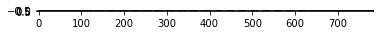

In [9]:
select = 1337
plt.imshow(X_train[select].reshape(1, -1))
print(f"Number {Y_train[select]} | Shape: {X_train[select].reshape(1, -1).shape}")

> Note: We have that shape because it is only one image and 28 (pixels) multiply by 28 equal 784.

# How it looks like?

To have some visual image of what we're going to build:

Source: https://github.com/fastai/fastbook/blob/master/01_intro.ipynb


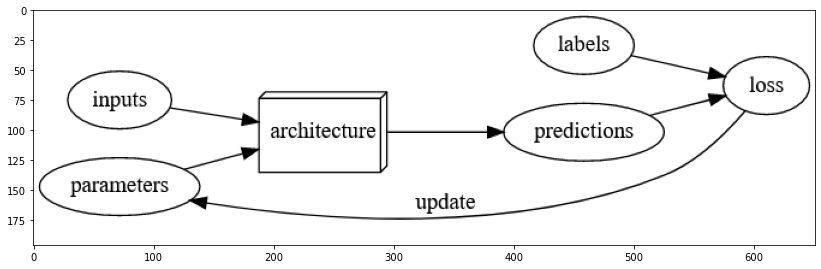

In [7]:
#hide_input
img = mpimg.imread('../images/fastai-NN.png')
plt.figure(figsize=(14, 12))
plt.imshow(img)
print("Source: https://github.com/fastai/fastbook/blob/master/01_intro.ipynb")

> Important: Through out this blog post I am using termininology in this image.

This is how a **Neural Network (NN)** looks like! Our inputs are MNIST images in the form of a NumPy 2D array (matrix), which contains numbers between `0 to 1`. Usually, we represent data between `0 to 1` or `-1 to 1` (It is an unwritten golden rule). **Architecture (model)** is basically our neural network. There we pass inputs through **nodes (neurons)**, which compute some operations with **parameters** and we get **predictions**. We then take **labels (targets)** and compare them with our prediction. We measure *how wrong* our model was with the **loss function** and use it to **update** **parameters** so it could "learn".

Maybe now is a good question `what is even neural network?`. It is inspired by neurons in our brain. Neuron "fire" signal if it gets a certain amount of input and millions of them can create complex structures. For our case, we won't need millions of them, but only a few. Right now there are three types of structure in the field: **linear, convolutional, and recurrent**. We are going to use the simplest and oldest one the **linear layer**:

```outputs = weights * inputs + biases```


As we can see it is a linear function. In our model, we won't use biases, so weights are the only parameters we will be updating in the training loop.

> Note: With this, our model will be learning on its own and when our programming function is creating its own function, we call it **machine learning**.

So far, so good, but to clarify how our architecture will look like: **every node (neuron) will be a linear function, and we stack them as a full layer and pass every input to every node, where each contains a parameter. We then stack multiple layers.**

This image (below) roughly show how a neural network looks like. Here it is defined with: *input layer (16 nodes), hidden layer 1 (12 nodes), hidden layer 2 (12 nodes), output layer (1 node)*.

Created with: https://alexlenail.me/NN-SVG/index.html


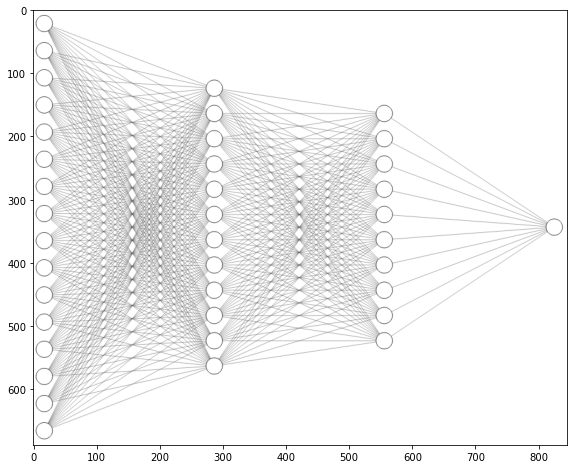

In [8]:
#hide_input
img = mpimg.imread('../images/connected layers.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
print("Created with: https://alexlenail.me/NN-SVG/index.html")

Each of those "strings" are **weights** (parameter) and we can see that every **node** has its own **weight** for every **node** from the previous **layer**. We will create only one **hidden layer** with 128 nodes. Our input layer is **flattened**, where each pixel is represented as one node in the **input layer**. The last layer is the **output layer**, and because we classify 0-9 images it will have 10 nodes.

> Note: When a neural network has more hidden layers we call it **deep learning** (which is a subset field of machine learning).

## PyTorch example

To show you everything we will be implementing from scratch I have prepared an example made with a popular deep learning library called **PyTorch**. Just hit the "show code" button to have a picture of what in the code we are going to implement (from scratch).

In [9]:
#collapse-hide
#hide-output
import torch
import torch.nn as nn
torch.manual_seed(7)

class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10)
        self.sm = nn.LogSoftmax(dim=1)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x
    
model = TorchNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in (t := trange(10000)):
    # Create Batch (randomly initiated)
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    
    # Pass through Net (+ calculate loss)
    output = model.forward(X)
    loss = loss_function(output, Y).mean()
    
    # Update parameters
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # Save for statistic
    cat = torch.argmax(output, dim=1)
    acc = (cat == Y).float().mean()
    accuracies.append(acc.item())
    losses.append(loss.item())
    
    t.set_description(f"Loss: {loss:.5f}; Acc: {acc:.5f}")

Loss: 0.02323; Acc: 0.99219: 100%|██████████| 10000/10000 [00:50<00:00, 198.29it/s]


It evaluated about `98-99%` on the testing set. We will be recreating this whole code from scratch. I recommend to use this section as reference.

# Neural network structure

As the first image show in the `How it looks like?`, we will be implementing everything that is there. The whole code for the neural network should be under 100 lines of code in Python.

## Parameters (Weights)

We're going to have three layers: *input layer (784 nodes)*, *hidden layer (128 nodes)*, and *output layer (10 nodes)*. We pass input to the first hidden layer and output will be **pass forward** to another layer to the next layer until it reaches the final layer (output layer). Each node will contain its own **parameter**, which will perform some operation with the input. We are going to use a simple linear layer (only **weights**), so our parameters will be only one array for each layer.

*Every* neural network library uses its own initiate functions that create usually numbers between `-1 to 1` or `0 to 1`. I chose `uniform function` because it performed best from what I have observed.

In [47]:
def init_uniform(a, b, dtype=np.float32):
    return np.random.uniform(-1., 1., size=(a, b)).astype(dtype) / np.sqrt(a*b)

> Note: We're going to use `np.float32` for accuracy. *All* popular neural network libraries use them by default.

In [48]:
# 784 because image from dataset is 28*28
w1 = init_uniform(784, 128) # layer one (weights) | represent input layer & hidden layer 1
w2 = init_uniform(128, 10)  # layer two (weights) | represent hidden layer 1 & output layer
w1.shape

(784, 128)

In the code, **weights** (w1 and w2) are *representing* whole layer. We can see in `init_uniform(784, 128)` and `init_uniform(128, 10)` we input the whole all three layers of our **model**.

## Architecture (Linear Layer & Activation function)

We are representing **linear layers** as inputs multiply by **weights**. To perform our linear pass we take one image from the training set and use `@` Python operator that multiply rows of first array with columns of second array. Alternatively in Numpy you can use `np.dot(a, b)`.

In [49]:
linear = lambda a, b: a @ b

In [50]:
img = X_train[0].reshape(-1)
x_l1 = linear(img, w1)
x_l1.shape

(128,)

Just to clarify how linear function looks like:

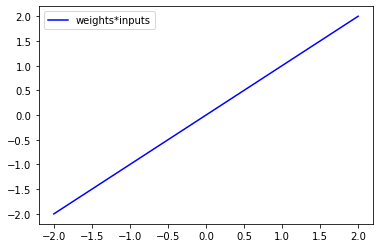

In [51]:
#hide-input
x = np.linspace(-2, 2, 2)
plt.plot(x, x, "b")
#x_ = np.linspace(-2, 2, 2)
#y_ = np.array([0, 0])
#plt.plot(x_, y_, "black")
#x_ = np.array([0, 0])
#y_ = np.linspace(-2, 2, 2)
#plt.plot(x_, y_, "black")
plt.legend(["weights*inputs"])
plt.show()

With linear layers, we use an **activation functions**. They are **non-linear function**. We use them to have non-linear outputs. Imagine your input data are, for example, sinus. If our architecture would be only made by a **linear function (linear layers)**, it couldn't learn how to "bend" output to something similar to the sinus.

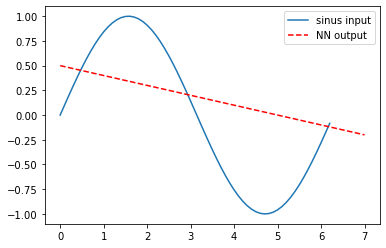

In [52]:
#hide-input
x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
xa = np.linspace(0, 7, 20)
ya = -xa*0.10+0.5
plt.plot(x,y)
plt.plot(xa, ya, 'r--')
plt.legend(["sinus input", "NN output"])
plt.show()

> Note: Another reason we use them is the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem). Basically, with only two linear layers, we could rewrite it as one linear layer, but with a non-linearity (in our case between them) and sufficiently big matrices, it can approximate any arbitrary function.

To be more precise one neuron could bend the first part and another neuron could move it up and another layer could flip it for the second part... (This is just example how it could be, but we always initialize parameters randomly and each time each neuron can have different output, which depend on previous layer of neuron.)

We use it after the **hidden layer**. Because we only classify It isn't a necessity, but we still get better performance. We implement **ReLU (Rectified linear unit)**, which is most used:

$$f(x)=max(0,x)$$

In [53]:
#hide-output
relu = lambda x: np.maximum(x, 0)

It looks like this:

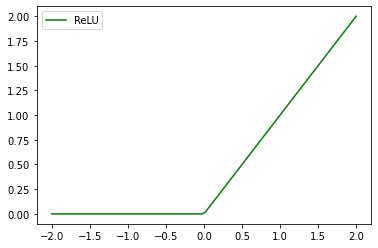

In [54]:
#hide-input
x = np.linspace(-2, 2, 100)
y = relu(x)
plt.plot(x, y, 'g')
plt.legend(["ReLU"])
plt.show()

Implementation with our code:

In [55]:
x_w1 = linear(X_train[0].reshape(1, -1), w1)
x_relu = relu(x_w1)
x_w2 = linear(x_relu, w2)
x_w2

array([[-0.6520123 , -0.24983323, -0.6080282 , -0.24861592, -0.35031724,
         0.60303384, -0.5354343 , -0.23014745, -0.36763242,  0.1088623 ]],
      dtype=float32)

That's it. We have a forward pass for our neural network. After we pass the image array, we get an output of *size 10*. But the real question is `How it will learn?`.

## Loss function
To teach neural network we have to figure out how to represented how big is an **error (difference)** between **prediction** and **label (target)**.

First, we need to get prediction (output) from the forward pass. We pass one of the images through our layers, that will give us an array of shape (10,). With the Numpy function `np.argmax()` we can extract that as a single number by the position of the biggest number in the array.

In [58]:
# image
select = 1337
Y = Y_train[select] # target / label
X = X_train[select].reshape(1, -1) # input

# Forward pass
x_w1 = linear(X, w1)
x_relu = relu(x_w1)
x_w2 = linear(x_relu, w2)  # output

output = np.argmax(x_w2) # Take biggest number in array (by position)

# Differences
print(f"Correct number: {Y}")
print(f"Prediction: {output}")

Correct number: 6
Prediction: 5


We can see its **prediction** is wrong. We need to calculate **error** between `output` and `label`. Our output `x_w2` is already array, so we need to transform label to array of same shape like `x_w2`, which is (10,). That can be done by using **one-hot encoded array**.

In [59]:
# Represent label as one-hot encoded array (target)
label_arr = np.zeros((10, ), np.float32)
label_arr[Y] = 1

# Differences
print(f"Correct number: {label_arr} ----> {Y}")
print(f"Prediction: {x_w2} ----> {output}")

Correct number: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] ----> 6
Prediction: [[-1.1656513  -0.39488536 -0.83915067 -0.42164934  0.39440176  1.1336713
   0.01601482 -1.4128247   0.02184126  0.12216576]] ----> 5


We will calculate the **error** during `backpropagation`, now we need to transform the output to **loss**, which "describe better"  the difference between **label** and **prediction**. Because we are classifying single digits, we have 10 categories. For that, we will use **Cross-Entropy Loss**. We want NN output to be a distribution of how much sure it is, which can be represented as a percentage between 0% to 100%. For that, we need transform (squish) data of prediction between 0 to 1. Activation function which handles that is called **Softmax**.

$$ \sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^Ke^{z_j}} $$

In [60]:
softmax = lambda x: np.exp(x) / np.exp(x).sum(axis=1)

> Note: Exponencial operation -> `np.exp(x)` is defined as `e ** x`, where `e` is special (magical) number like `pi`. Its value is approximately equal to 2.718.

In [61]:
softmax(x_w2)

array([[0.03093783, 0.06686967, 0.0428832 , 0.06510371, 0.1472354 ,
        0.30837056, 0.10085116, 0.0241626 , 0.10144047, 0.11214544]],
      dtype=float32)

If we sum **Softmax** together, we get single digit.

In [62]:
softmax(x_w2).sum()

1.0

The function will calculate the probabilities of each label class over all possible label classes (useful for classifying -> multi-category array). With this, we can get the **confidence** of our neural network.

In [63]:
s_out = softmax(x_w2)
print(f"{round(100 * s_out[0][output], 4)}%") 

30.8371%


Right now it is not confident about its own result. We will later in `Backpropagation` compare it to our one-hot encoded label (target) to say neural network *how wrong it was*.

But the problem with **Softmax** is that during `Backpropagation`, neural network wouldn't "*see*" the difference between 0.99 and 0.999 despite that it is 10 times bigger. To magnify this difference, we will use **Negative Log-Likelihood (NLL)**, which uses a logarithm.

In [65]:
nll_loss = lambda x: np.log(x)

> Important: I don't use a negative logarithm for computational reason later in the `backward pass`.

Logarithm is inverted exponencial:

$$z = x^y$$
$$y = \log{_x}{z}$$

> Note: Before computers, we used it to calculate the largest or smallest numbers.

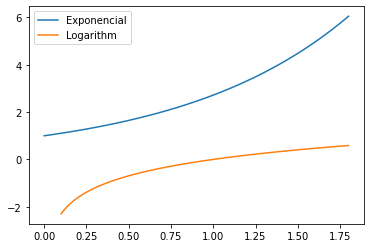

In [20]:
#hide-input
x = np.linspace(0, 1.8, 100)
y = np.exp(x)
plt.plot(x, y)
x = np.linspace(0.1, 1.8, 100)
y = np.log(x)
plt.plot(x, y)
plt.legend(["exponential", "Logarithm"])
plt.show()

Our biggest number will become our smallest number in the array, and the difference between other numbers will be more significant.

In [67]:
loss = nll_loss(s_out)

print(f"Softmax: {s_out} \nSum: {s_out.sum()}\n")
print(f"NLL: {loss} \nSum:: {loss.sum()}")

Softmax: [[0.03093783 0.06686967 0.0428832  0.06510371 0.1472354  0.30837056
  0.10085116 0.0241626  0.10144047 0.11214544]] 
Sum: 1.0

NLL: [[-3.4757757 -2.7050097 -3.149275  -2.7317739 -1.9157226 -1.1764531
  -2.2941096 -3.7229493 -2.288283  -2.1879587]] 
Sum:: -25.64731216430664


We just need to bundle it together and we get **Cross-Entropy Loss**:

$$H_{\textrm{(p, q)}} = - \sum_{x\epsilon{X}}p(x)\log{_q}(x)$$

that can be written like this in a code:

In [2]:
crossentropyloss = lambda x: np.log(np.exp(x) / np.exp(x).sum(axis=1)) # NLL & Softmax

We have our **loss function**, but we won't be implementing it in the `forward pass`. We use the **loss function** to **update** our **parameters**, which are `w1` and `w2`, so it will be implemented in `backward pass`.

### Stable code

As a side note, there is a computationally more stable way of the code of our loss function, which I will use. It's an explanation you can find [here](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/).

In [4]:
# from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb
# and from: # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
def logsumexp(x):
    c = x.max(axis=1)
    return x - (c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))).reshape((-1, 1))

It seems like it is different, but it results in the same output as our previous function:

In [70]:
loss1 = crossentropyloss(x_w2)
loss2 = logsumexp(x_w2)
loss1.sum(), loss2.sum()

(-25.647312, -25.647308)

## Backpropagation

The fundamental question is **'How do you meaningfully update parameters?'**. The answer is we use `derivatives of functions` we implemented in `architecture` (model). Derivatives are representing the slope of the original function. All those results from each layer give us a  *multidimensional representation* called `gradient descent`. We calculate them to find how much we need to increase or decrease parameters so we would decrease a **loss** and update **parameters**. This part is conceptually the hardest one to understand.

When we compare the desired result with the output of our neural network, we then get a loss, which tells us how wrong is our model. We then propagate it (back) to each layer to each neuron (linear function), which is wrapped around the activation function.

Every function has its derivative. What is derivative? In simple term, it describes a change of slope in each point of a function. Imagine you start a car, and you ride it first 100 meters and then stop. If you would plot its distance over time (it took 10s for 100m) probably you wouldn't get a linear graph, but something like this:

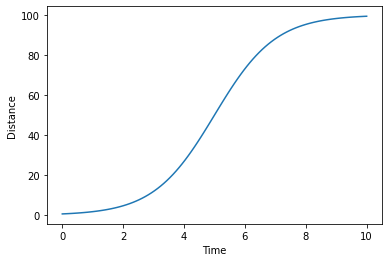

In [98]:
#hide-input
signmoid_function = lambda x: 100 / (1 + np.exp(-x))
# sigmoid graph
xs = np.linspace(-5, 5, 100)
ys = signmoid_function(xs)
xs += 5
plt.plot(xs, ys)
plt.xlabel("Time")
plt.ylabel("Distance")
# point 
#plt.plot(5, 50, "r", marker="o")
#plt.plot(np.array([4.6, 5.4]), np.array([40, 60]), "r")
plt.show()

You first start slowly as the car is increasing its speed, then you slow down. By watching the change of speed, we can plot its derivative.

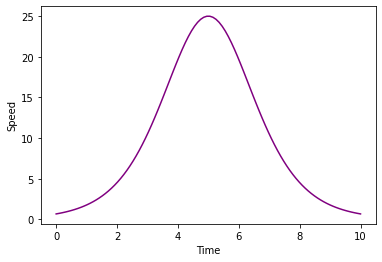

In [99]:
#hide-input
signmoid_function = lambda x: 1 / (1 + np.exp(-x))
derivative_f = lambda x: signmoid_function(x) * (1 - signmoid_function(x)) * 100
xs = np.linspace(-5, 5, 100)
ys = derivative_f(xs)
xs += 5
plt.plot(xs, ys, 'purple')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.show()

> Note: This is the actual activation function (with its derivate) that was popular before ReLU, and It's called the [Sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).

**So why bother with this?** When we get a loss, which is a measurement of how wrong is our model, we need to figure out how much we want to tweak weights to decrease loss ('how wrong'). The problem is, if we tweak one neuron at the beginning, it can change the entire output of the neural network, so we first send loss back to the previous layer and then to the previous layer of the previous layer and so on... (**backpropagation**).

There (for each layer), we want to figure how much we want to tweak the weight of neurons and in which direction (make it bigger or smaller). But with many neurons, our derivatives are represented in multi-dimensions (gradient descent). So for simplicity, I will plot **gradient descent** in 2D:

Let's say we have some small linear hidden layer with a loss function and we get this gradient descent:

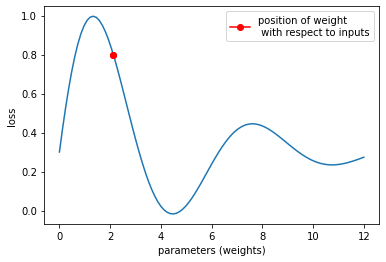

In [71]:
#hide-input
plt.plot(2.1, 0.8, "r", marker="o")
xa = np.linspace(0, 12, 100)
ya = np.sin(xa)*np.exp(-xa/4) + 0.3
dot = np.array([])
plt.plot(xa, ya)
plt.xlabel("parameters (weights)")
plt.ylabel("loss")
plt.plot(2.1, 0.8, "r", marker="o")
plt.legend(["position of weight\n with respect to inputs"])
plt.show()

Our goal is to **update parameters** (weights) to decrease a loss. We want to move weight somewhere where it will have the least effect on a loss, so in another word: **by decreasing the loss we increase model accuracy**. With that, we need to know the change of slopes to find the most stable place, which we find with the derivative.

We want to move that red dot to the **global minimum**, which is the smallest possible point on the y-axis.

We can see here we want to move to the right, but the question is how we want to move it and how we can figure it out in a code?

We want to get a `slope of weight`. We can find it by comparing the two nearest points (weight of neuron and next to it)

$$slope = \frac{y2 - y1}{x2 - x1}$$

, where (x1, y1) and (x2, y2) are coordinations. With this we can find in which direction we want to go (up or down = bigger or smaller):

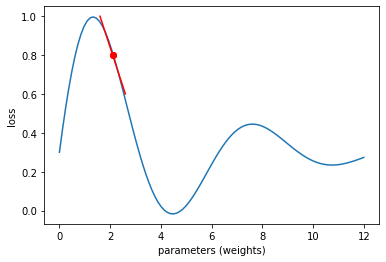

In [72]:
#hide-input
dot = np.array([[2.1], [0.8]])
plt.plot(dot[0], dot[1], "r", marker="o")
xa = np.linspace(0, 12, 100)
ya = np.sin(xa)*np.exp(-xa/4) + 0.3
plt.plot(xa, ya)
plt.xlabel("parameters (weights)")
plt.ylabel("loss")
plt.plot(dot[0], dot[1], "r", marker="o")
xb = np.array([1.6, 2.1, 2.6])
yb = np.array([1., 0.8, 0.6])
plt.plot(xb, yb, "r")
plt.show()

So we've figured out that we need to move to the right. But this method has its limitations. When we get to the valley that resembles quadratic function if we take some point next to our, we can get an inaccurate slope like here:

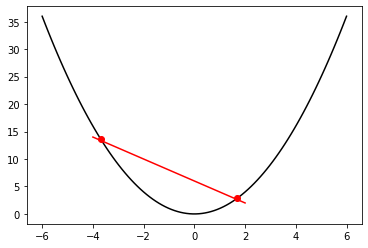

In [82]:
#hide-input
def linear_function(x, a=-2, b=-1):
    return a * x + b
x_ = np.linspace(-6, 6, 100)
y_ = x_ ** 2
plt.plot(x_, y_, "black")
x = np.linspace(-4, 2, )
y = linear_function(x) + 7
plt.plot(x, y, "r")
plt.plot(-3.7, 13.7, "r", marker="o")
plt.plot(1.7, 2.9, "r", marker="o")
plt.show()

We could take an even smaller point, but this could later have some problems with floats in python. Better solutions are to use calculus to get derivative function. We've already done it in the previous example with the car and its speed, but just as a graph.

In our case, we only need a derivative of **Linear, ReLU and LogSoftmax** (logsumexp in my case) function.

Luckily other people already figured out this stuff for us, but if you're interested in doing it yourself, I recommend this [playlist](https://youtube.com/playlist?list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr) or [Khan Academy](https://www.khanacademy.org/math/calculus-all-old/taking-derivatives-calc) to learn more about derivate.

For the **linear layer**, we only need to multiply it with the previous layer. For **LogSoftmax** I'll use the solution [here](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/#derivative-of-the-softmax). But we can utilize what we know to figure out ReLU.

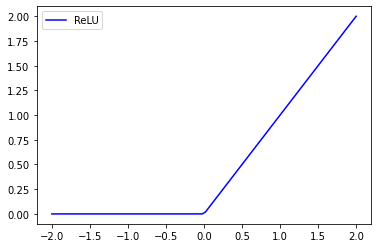

In [87]:
#hide-input
relu = lambda x: np.maximum(x, 0)
x = np.linspace(-2, 2, 100)
y = relu(x)
plt.plot(x, y, 'blue')
plt.legend(["ReLU"])
plt.show()

We want to know the change of slope over time (x-axis), but as we can see it is constant, so our derivation will look like this:

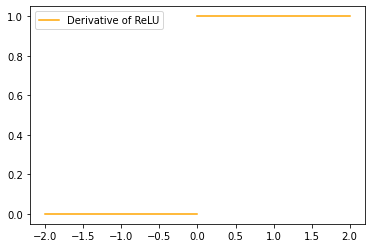

In [94]:
#hide-input
relu = lambda x: np.maximum(x, 0)
derivative_relu = lambda x: np.where(x <= 0, 0, 1)
x = np.linspace(-2, -0.000001, 100)
y = derivative_relu(x)
plt.plot(x, y, 'orange')
x = np.linspace(0.00001, 2, 100)
y = derivative_relu(x)
plt.plot(x, y, 'orange')
plt.legend(["Derivative of ReLU"])
plt.show()

We can easily write this in a pseudo-code:

$$f'(x) = 0 \textrm{ (if } {x' < 0)} \textrm{ else } \textrm{x} \textrm{ (if } {x' >= 0)} $$ 

The missing piece for completion is to know how much we want to push it in the right direction, so for that, we use **learning rate** and **optimizer** (next chapters).

To pack everything in a code:

In [76]:
#hide-output
X = X_train[1337].reshape(1, 784)
Y = np.array(Y_train[1337]).reshape(-1) # <- target

## backward pass
# target -> one-hot encoded
out = np.zeros((len(Y), 10), np.float32)
out[range(out.shape[0]), Y] = 1

# crossentropyloss
x_lsm = logsumexp(x_w2)

# Chain of derivates
# derivative of target
d_out = -out / len(Y)

# derivative of loss with respect to target
dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))

# derivative of l2
d_w2 = x_relu.T @ dx_lsm

# derivative of ReLU
d_relu = dx_lsm @ w2.T
d_relu[x_w1 < 0] = 0

# derivative of l1
d_w1 = X.T @ d_relu

> Note: '@' operation means matrix multiplication

## Optimizer

We will use a simple one called **SGD (Stochastic gradient descent)**. We will need a **learning rate** to say **derivatives of parameters** *how big step* we want to do in the **gradient descent** and update **parameters**. If our learning rate is too big, it will not reach global minimum (it will over shoot it). 

If our learning rate is too small, it will get stuck at a local minimum (obviously we want global minimum).

Source: https://www.bdhammel.com/learning-rates/


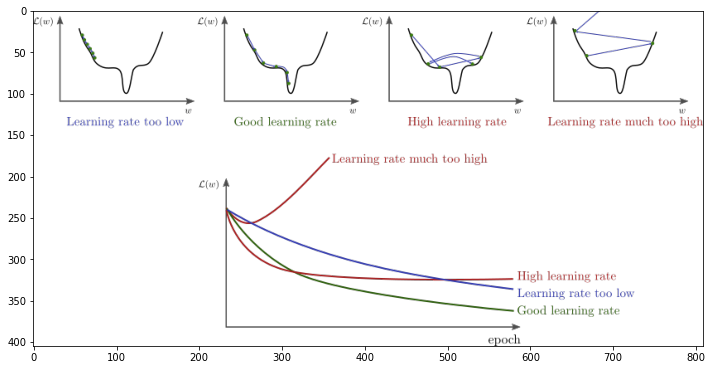

In [77]:
#hide-input
img = mpimg.imread('../images/learning_rate-dl.png')
plt.figure(figsize=(12, 10))
plt.imshow(img)
print("Source: https://www.bdhammel.com/learning-rates/")

Code:

In [78]:
#hide-output
# learning rate
lr = 0.001

# SGD
w1 += -lr * d_w1
w2 += -lr * d_w2

> Note: The reasons for the learning rate to be that "*small*" is that our weights are initiated between -1 to 1.

That's all! We just need to construct a **training loop** and also **batches of data**.

# Prepare data in a batches

So far we have been reshaping data with the shape (1, 784), but we will be computing multiple images at once for better results to achieve better **generalizing**. We initiate batch randomly.

In [79]:
#hide-output
batch_size = 128
samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
X = X_train[samp].reshape((-1, 28*28))
Y = Y_train[samp]

Commonly is used batch sizes of 64, 128, 256. We have to be careful with **batch sizes** and **learning rate**; else we could **overfit** the model. That means our model would "memorize" and not **generalize (optimal)**, which would result in worse performance on new unseen data (you can try it by initiating batches orderly).

Source: https://www.fastaireference.com/overfitting


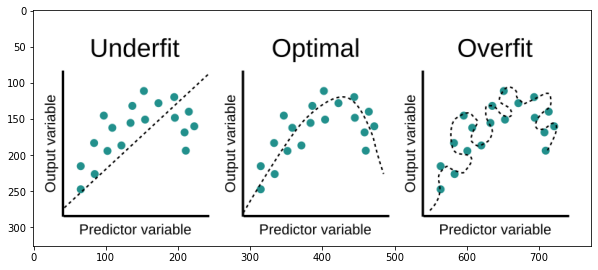

In [80]:
#hide-input
img = mpimg.imread('../images/overfitting-dl.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
print("Source: https://www.fastaireference.com/overfitting")

# Constructing training loop

When we get output from our model we treat it as **one-hot encoded** array and we transform it to a single number than we compare it with **labels (targets)** to keep track of **accuracy**. Also, we will track **loss** (which we need to sum together -> to get single value). After the training loop, we will plot losses and accuracies.

In [81]:
output = x_w2
cat = np.argmax(output, axis=1) # from (10,) to (1)
acc = (cat == Y).mean()

x_loss = (-out * x_lsm).mean(axis=1)
loss = x_loss.mean()
loss, acc, cat

(0.22941096, 0.1171875, array([5], dtype=int64))

Let's construct everything together and run it:

In [85]:
#hide
def init_uniform(a, b, dtype=np.float32): 
    return np.random.uniform(-1., 1., size=(a, b)).astype(dtype) / np.sqrt(a*b)

linear = lambda a, b: a @ b

relu = lambda x: np.maximum(x, 0)

def logsumexp(x):
    c = x.max(axis=1)
    return x - (c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))).reshape((-1, 1))

Loss: 0.00142; Acc: 0.99219: 100%|██████████| 10000/10000 [00:41<00:00, 240.13it/s]


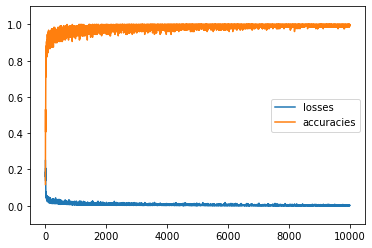

In [86]:
# parameters
w1 = init_uniform(784, 128)
w2 = init_uniform(128, 10)

lr = 0.001
batch_size = 128
losses, accuracies = [], []
## Train
for i in (t := trange(10000)):
    # Batch of training data & target data
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    
    ## Forward pass
    x_w1 = linear(X, w1)
    x_relu = relu(x_w1)
    x_w2 = linear(x_relu, w2)
    output = x_w2
    
    ## backward pass
    # target -> one-hot encoded
    out = np.zeros((len(Y),10), np.float32)
    out[range(out.shape[0]), Y] = 1
    
    # crossentropyloss
    x_lsm = logsumexp(x_w2)
    
    # loss
    x_loss = (-out * x_lsm).mean(axis=1)
    loss = x_loss.mean()

    # derivative of target
    d_out = -out / len(Y)

    # derivative of loss with respect to target
    dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))

    # derivative of l2
    d_w2 = x_relu.T @ dx_lsm

    # derivative of ReLU
    d_relu = dx_lsm @ w2.T
    d_relu[x_w1 < 0] = 0

    # derivative of l1
    d_w1 = X.T @ d_relu
    
    ## Update
    # SGD
    w1 += -lr * d_w1
    w2 += -lr * d_w2
    
    # Save for statistic
    cat = np.argmax(output, axis=1)
    acc = (cat == Y).mean()
    accuracies.append(acc)
    losses.append(loss)
    
    t.set_description(f"Loss: {loss:.5f}; Acc: {acc:.5f}")
    
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)
plt.legend(["losses", "accuracies"])
plt.show()

It looks good, but we need to evaluate it. We do it by inputting the whole testing set. We don't need the backward pass anymore if we don't plan to update it.

In [87]:
## Evaluation
# Forward pass
x_w1 = linear(X_test.reshape((-1, 28*28)), w1)
x_relu = relu(x_w1)
output = linear(x_relu, w2)

# Measure accuracy
Y_test_preds = np.argmax(output, axis=1)
true_acc = (Y_test == Y_test_preds).mean()
print(f"Accuracy on testing set: {true_acc}")

Accuracy on testing set: 0.9798


We have successfully build a neural network from scratch that evaluates around the human level. **Here is the whole code: (I have edited little the code to resemble more PyTorch example):**

Loss: 0.00065; Acc: 1.00000: 100%|██████████| 10000/10000 [00:46<00:00, 215.81it/s]


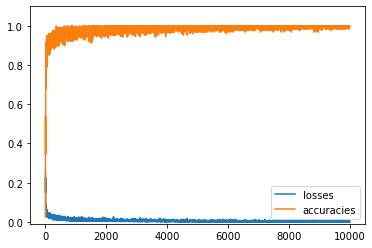

Accuracy on testing set: 0.9811


In [10]:
#collapse-hide
#hide-output
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import requests, gzip
from pathlib import Path

def fetch(url):    
    name = url.split("/")[-1]
    dirs = Path("dataset/mnist")
    path = (dirs / name)
    if path.exists():
        with path.open("rb") as f:
            dat = f.read()
    else:
        if not dirs.is_dir():
            dirs.mkdir(parents=True, exist_ok=True)
        with path.open("wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

def mnist_dataset():
    X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
    Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
    Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]
    return (X_train, Y_train, X_test, Y_test)
X_train, Y_train, X_test, Y_test = mnist_dataset()


class Net:
    def __init__(self, lr=0.001):
        # parameters
        self.w1 = self.init_uniform(784, 128)
        self.w2 = self.init_uniform(128, 10)
        self.lr = lr
    
    @staticmethod
    def init_uniform(a, b, dtype=np.float32):
        return np.random.uniform(-1., 1., size=(a, b)).astype(dtype) / np.sqrt(a*b)
    
    @staticmethod
    def relu(x): return np.maximum(x, 0)
    
    @staticmethod
    def linear(a, b): return a @ b
        
    @staticmethod
    def logsumexp(x):
        c = x.max(axis=1)
        return x - (c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))).reshape((-1, 1))
    
    def calc_loss(self):
        # crossentropyloss
        self.x_lsm = self.logsumexp(self.x_w2)
        self.loss = (-self.out * self.x_lsm).mean(axis=1).mean()
    
    def calc_optim(self):
        # Update (SGD)
        self.w1 += -self.lr * self.d_w1
        self.w2 += -self.lr * self.d_w2
    
    def forward(self, X):
        self.X = X
        self.x_w1 = self.linear(X, self.w1)
        self.x_relu = self.relu(self.x_w1)
        self.x_w2 = self.linear(self.x_relu, self.w2)
        return self.x_w2
    
    def backward(self, Y):
        # target -> one-hot encoded
        self.out = np.zeros((len(Y),10), np.float32)
        self.out[range(self.out.shape[0]), Y] = 1
        # loss function
        self.calc_loss()
        # derivative of target
        d_out = -self.out / len(Y)
        # derivative of loss with respect to target
        dx_lsm = d_out - np.exp(self.x_lsm) * d_out.sum(axis=1).reshape((-1, 1))
        # derivative of l2
        self.d_w2 = self.x_relu.T @ dx_lsm
        # derivative of ReLU
        d_relu = dx_lsm @ self.w2.T
        d_relu[self.x_w1 < 0] = 0
        # derivative of l1
        self.d_w1 = self.X.T @ d_relu
        

net = Net()
batch_size = 128
losses, accuracies = [], []
## Train
for i in (t := trange(10000)):
    # Batch of training data & target data
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    
    output = net.forward(X)
    net.backward(Y)
    net.calc_optim()
    
    # Save for statistic
    cat = np.argmax(output, axis=1) # results from Net
    acc = (cat == Y).mean()
    accuracies.append(acc)
    losses.append(net.loss)
    
    t.set_description(f"Loss: {net.loss:.5f}; Acc: {acc:.5f}")
    
plt.ylim(-0.01, 1.1)
plt.plot(losses)
plt.plot(accuracies)
plt.legend(["losses", "accuracies"])
plt.show()

## Evaluation
Y_test_preds = np.argmax(net.forward(X_test.reshape((-1, 28*28))), axis=1)
true_acc = (Y_test == Y_test_preds).mean()
print(f"Accuracy on testing set: {true_acc}")

You can compare it with the code from the PyTorch example and see differences.

## Try it (Binder)

If you want to try NN right now, I have prepared here widgets for uploading and passing images to NN. Those widgets won't show up here, so you need to click on the **Binder** button at the beginning of this blog post. It will generate a jupyter notebook of this blog post in your browser. Be sure to have all pip dependencies installed. Then run all relevant cells and go to this section and here you will see widgets for uploading and evaluating image (the image will be automatically rescaled to 28x28 and converted to grayscale):

In [ ]:
from ipywidgets import VBox, FileUpload, Button, Output, Label
from IPython.display import display
from PIL import Image, ImageOps
import io

btn_upload = FileUpload()
btn_run = Button(description="Classify")
out_pl = Output()
lbl_pred = Label()

def on_click_classify(change):
    # Convert Image from bytes to PIL format and than to numpy array
    fn = io.BytesIO(btn_upload.data[-1])
    img = Image.open(fn).resize((28, 28))
    img_ = ImageOps.grayscale(img)
    arr = np.asarray(img_)
    
    # get values from NN and show them
    output = net.forward(arr.reshape((1, 28*28)))
    predict = np.argmax(output, axis=1)
    confid = softmax(output)
    
    # display
    out_pl.clear_output()
    with out_pl: 
        display(img_)
        lbl_pred.value = f"Prediction: {predict[0]}; Confidence: {confid[0][predict[0]]:.4f}"
    
btn_run.on_click(on_click_classify)
VBox([Label("Select your digit! (will classify last uploaded)"), 
      btn_upload, btn_run, out_pl, lbl_pred])

# Conclusion

I hope it helped. We made a neural network that classifies digits on a human level. Despite that our neural network is specialized only for classification, I still think it is impressive to build something like this from scratch.